# ECON526: Assignment 4

## Student Name/Number: Ryan Quek 81771206

### Instructions

-   Ensure you modify the field above with your **name and student
    number above immediately**
-   Modify directly and save as the `.ipynb`, and submit directly. Do
    not export to PDF or HTML, and leave the filename as is. Canvas will
    automatically append your name to the filename.
-   Submit directly to canvas as a `.ipynb` file.

## Setup

Feel free to use the following packages (and we have added a few
convenience imports)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from sklearn.metrics import confusion_matrix

# Q1

Take the following code from our PCA examples in class:

In [3]:
N = 50 # number of observations
L, M = 2, 3 # number of latent and observed factors
Z = np.random.randn(N, L) # latent factors
F = np.array([[1.0, 0.05], # X_1 = Z_1 + 0.05 Z_2
              [2.0, 0.0], # X_2 = 2 Z_1
              [3.0, 0.1]]) # X_3 = 3 Z_1 + 0.1 Z_2
X = Z @ F.T + 0.1 * np.random.randn(N, M) # added noise
pca = PCA(n_components=2) # one less, and correctly specified
Z_hat = pca.fit_transform(X) # transformed by dropping last factor
# Scale and sign may not match due to indeterminacy
print(f"Correlation of Z_1 to Z_hat_1 = {np.corrcoef(Z.T, Z_hat.T)[0,2]}")
print(f"Correlation of Z_2 to Z_hat_2 = {np.corrcoef(Z.T, Z_hat.T)[1,3]}")

Correlation of Z_1 to Z_hat_1 = -0.9995608493756525
Correlation of Z_2 to Z_hat_2 = -0.4609952820844761


# Q1.1

We said that it was doing a terrible job at separating out the 2nd from
the 3rd latent factor. Can you show code to demonstrate this and then
provide a description of why you think it is happening?

In [4]:
with np.printoptions(precision=4, suppress=True, threshold=5):
  print(f"Singular Values (sqrt eigenvalues):\n{pca.singular_values_}")
  print(f"Explained Variance (ordered):\n{pca.explained_variance_ratio_}")

Singular Values (sqrt eigenvalues):
[29.802   0.7169]
Explained Variance (ordered):
[0.999  0.0006]


The explained variance for the 2nd latent factor is too small, and most of the explained variance is from the first latent factor. This is because the noise that was added is large compared to the coefficients used in Z2 (0.1, 0.05 and 0), meaning the noise might be covering up the effect that the 2nd latent factor brings to the equation. 

# Q1.2

Change the $F$ matrix in our previous code - leave the noise and other
parameters intact - to make it so that it is more clearly a data
generating process with 2 latent factors as is specified. Hint: get
better separation between 2nd and 3rd singular values

In [5]:
N = 50 # number of observations
L, M = 2, 3 # number of latent and observed factors
Z = np.random.randn(N, L) # latent factors
F = np.array([[2, 7], 
              [4, 4],
              [7, 1]]) 
X = Z @ F.T + 0.1 * np.random.randn(N, M) # added noise
pca = PCA(n_components=3) # one less, and correctly specified
Z_hat = pca.fit_transform(X) # transformed by dropping last factor
# Scale and sign may not match due to indeterminacy
print(f"Correlation of Z_1 to Z_hat_1 = {np.corrcoef(Z.T, Z_hat.T)[0,2]}")
print(f"Correlation of Z_2 to Z_hat_2 = {np.corrcoef(Z.T, Z_hat.T)[1,3]}")

with np.printoptions(precision=4, suppress=True, threshold=5):
  print(f"Singular Values (sqrt eigenvalues):\n{pca.singular_values_}")
  print(f"Explained Variance (ordered):\n{pca.explained_variance_ratio_}")

Correlation of Z_1 to Z_hat_1 = 0.8070913618984077
Correlation of Z_2 to Z_hat_2 = 0.7188856960573939
Singular Values (sqrt eigenvalues):
[71.721  33.2424  0.7777]
Explained Variance (ordered):
[0.8231 0.1768 0.0001]


# Q1.3

This example contains the same $F$ as the original.

In [6]:
N = 50 # number of observations
L, M = 2, 3 # number of latent and observed factors
Z = np.random.randn(N, L) # latent factors
F = np.array([[1.0, 0.05], # X_1 = Z_1 + 0.05 Z_2
              [2.0, 0.0], # X_2 = 2 Z_1
              [3.0, 0.1]]) # X_3 = 3 Z_1 + 0.1 Z_2
X_new = Z @ F.T + 1e-16 * np.random.randn(N, M) 
print(PCA(n_components=3).fit(X_new).singular_values_)
print(PCA(n_components=3).fit(X_new).explained_variance_ratio_)

[2.62090823e+01 4.33501084e-01 1.08130540e-15]
[9.99726500e-01 2.73500390e-04 1.70166598e-33]


Give an explanation for the key differences of these results compared to
our baseline

The noise is reduced to become near zero, and it is significantly smaller than the coefficients of Z2.
The effect Z2 will have is clearly specified in the PCA, and the noise does not cover the differences.

## Q2.1

The clustering example we gave in class worked quite well. Modify the
example to make it perform worse and briefly explain why

In [23]:
# Modify this directly for your example
mu_1 = np.array([0.0, 0.0]) # mean of k=1
mu_2 = np.array([0.5, 0.5]) # mean of k=2
sigma = np.array([[0.5, 0], [0, 0.5]]) # use same variance
N = 100 # observations
X_1 = np.random.multivariate_normal(mu_1, sigma, N)
X_2 = np.random.multivariate_normal(mu_2, sigma, N)
df_1 = pd.DataFrame({"f1": X_1[:, 0], "f2": X_1[:, 1], "k": 1})
df_2 = pd.DataFrame({"f1": X_2[:, 0], "f2": X_2[:, 1], "k": 2})
df = pd.concat([df_1, df_2], ignore_index=True)
kmeans = KMeans(n_clusters=2, random_state=0)
df["k_hat"] = kmeans.fit_predict(df[["f1", "f2"]]) + 1
cm = confusion_matrix(df["k"], df["k_hat"])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted k')
plt.ylabel('True k')
plt.title('Confusion Matrix for K-Means Clustering')
plt.show()

#The variance and the mean of k=2 is the same, meaning that the overlap between k=1 and k=2 will be significant.
#This makes it harder to do the k-means clustering as there is no significant differences between the two groups. 

c:\Users\Ryan Quek\Documents\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Q2.2

Repeat the same thing as Q2.1, but change a different parameter to make
it perform worse in a different way. Briefly explain why

c:\Users\Ryan Quek\Documents\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


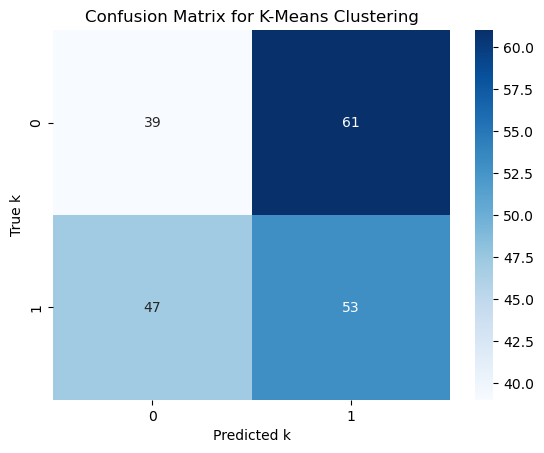

In [24]:
# Modify this directly for your example
mu_1 = np.array([0.0, 0.0]) # mean of k=1
mu_2 = np.array([0.0, 0.0]) # mean of k=2
sigma = np.array([[0.2, 0], [0, 0.2]]) # use same variance
N = 100 # observations
X_1 = np.random.multivariate_normal(mu_1, sigma, N)
X_2 = np.random.multivariate_normal(mu_2, sigma, N)
df_1 = pd.DataFrame({"f1": X_1[:, 0], "f2": X_1[:, 1], "k": 1})
df_2 = pd.DataFrame({"f1": X_2[:, 0], "f2": X_2[:, 1], "k": 2})
df = pd.concat([df_1, df_2], ignore_index=True)
kmeans = KMeans(n_clusters=2, random_state=0)
df["k_hat"] = kmeans.fit_predict(df[["f1", "f2"]]) + 1
cm = confusion_matrix(df["k"], df["k_hat"])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted k')
plt.ylabel('True k')
plt.title('Confusion Matrix for K-Means Clustering')
plt.show()

#Similarly, the two groups have the same distribution, making them pretty much indistinguishable.
# As such, the result of the confusion matrix will be nearly 50-50. 

# Q3.2

Take the following example of generated data and latents

In [25]:
def generate_noisy_circle(radius, num_points, noise_std):
    theta = np.linspace(0, 2*np.pi, num_points)
    x = radius * np.cos(theta) + np.random.normal(0, noise_std, num_points)
    y = radius * np.sin(theta) + np.random.normal(0, noise_std, num_points)
    return np.column_stack((x, y))

# Generate data for inner and outer circles
X_1 = generate_noisy_circle(0.5, 100, 0.05)
X_2 = generate_noisy_circle(1.5, 100, 0.05)

# Create dataframes
df_1 = pd.DataFrame({"f1": X_1[:, 0], "f2": X_1[:, 1], "k": 0})
df_2 = pd.DataFrame({"f1": X_2[:, 0], "f2": X_2[:, 1], "k": 1})
df = pd.concat([df_1, df_2], ignore_index=True)
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, x="f1", y="f2", hue="k", ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2", title="Latent Groups")
plt.show()

Note that the `k=0` and `k=1` state are fully separated and the
difference is visually obvious. Now lets perform k-means clustering

c:\Users\Ryan Quek\Documents\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


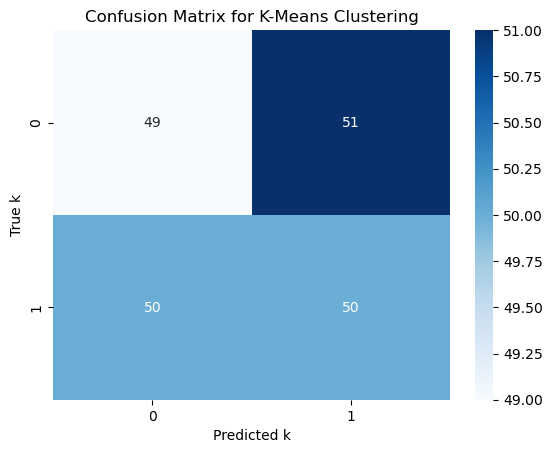

In [26]:
#Note: There was no Q3.1 in the problem set.
kmeans = KMeans(n_clusters=2, random_state=0)
df["k_hat"] = kmeans.fit_predict(df[["f1", "f2"]])

# Create confusion matrix
cm = confusion_matrix(df["k"], df["k_hat"])

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted k')
plt.ylabel('True k')
plt.title('Confusion Matrix for K-Means Clustering')
plt.show()

Can you explain why this was a failure using your knowledge of k-means
clustering? Be precise if possible.

The Means of the two groups are similar. Given k-means uses the euclidean distance to judge whether a given spot is nearer to k1 or k0, there is an assumption that the two centroids are far from each other, which is not the case in this one. Therefore, when it randomly initialises the centroid and tries to put the points into clusters, it will tend to group one side of the graph together, and the other side together, as seen below. After repeated iterations of re-sorting the clusters, given the already inaccurate initial assigned centroids, it simply spirals and settles on the centroids that are totally inaccurate (see the graph below).

In [27]:
centroids=kmeans.cluster_centers_
scatter=plt.scatter(df['f1'], df['f2'], c=df['k_hat'], cmap='viridis', marker='o', edgecolor='k')
scatter=plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
# Add titles and labels
plt.title('K Means results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Clusters")
plt.grid()
plt.show()

c:\Users\Ryan Quek\Documents\Anaconda3\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


But all is not lost! Look at the results of the following code which
uses a different algorithm

In [28]:
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
df["k_hat"] = spectral_clustering.fit_predict(df[["f1", "f2"]])

# Create confusion matrix
cm = confusion_matrix(df["k"], df["k_hat"])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted k')
plt.ylabel('True k')
plt.title('Confusion Matrix for K-Means Clustering')
plt.show()

c:\Users\Ryan Quek\Documents\Anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Ryan Quek\Documents\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Lookup [spectral
clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)
in skikit-learn docs, etc. and provide a 2 sentence summary of why this
worked.

Spectral Clustering is specifically designed to get around the issue of non-convex distributions or if the clusters are circles (like the ones we saw above). By using k-Nearest Neighbour algorithm, the two clusters will be very obvious, as the nearest neighbours of k1 are clearly k1 (as seen in the Latent Groups visualisation above.)

# Q4

Consider the following map

$$
x_{t+1} = f(x_t) = a x_t^2 + (1-a)
$$

Where we will assume that $a=\frac{3}{4}$. The code below comes from the
lecture notes, and can be used to simulate this map

In [199]:
def simulate(f, X_0, T):
    X = np.zeros((1, T+1))
    X[:,0] = X_0
    for t in range(T):
        X[:,t+1] = f(X[:,t])
    return X
def f(x, a):
    return a * x**2 + (1-a)
T = 10
x_0 = 0.1
X = simulate(lambda x : f(x, 3/4), x_0, T) # use a=3/4
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(T+1), X.T)

# Q4.1

If I solve the equation $x^* = f(x^*)$ for $x^*$ using the quadratic
formula you get the following:

In [200]:
def x_star(a):
  return [(1 + np.sqrt(1 - 4 * a*(1-a)))/(2*a),(1 - np.sqrt(1 - 4 * a*(1-a)))/(2*a)]  
print(f"x^* = {x_star(3/4)}")

x^* = [1.0, 0.3333333333333333]


Adjust the above code to simulate up to $T=5$ from $x_0 = 0.9$ and
$x_0 = 1.1$ and plot the results.

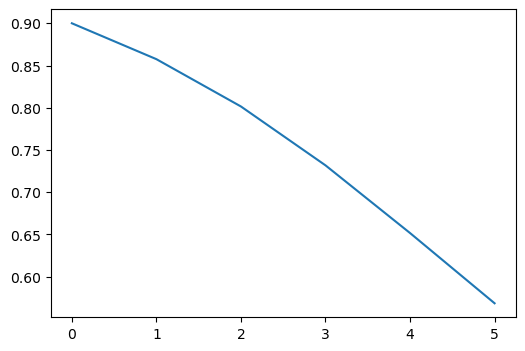

In [202]:
# Modify this code
T = 5
x_0=0.9
X = simulate(lambda x : f(x, 3/4), x_0, T) # use a=3/4
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(T+1), X.T)

x_0=1.1
X = simulate(lambda x : f(x, 3/4), x_0, T) # use a=3/4
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(T+1), X.T)

What do you notice about this and how do you intepret the different
behavior for various $x_0$?

For T = 0.9, the graph is going downwards, and seems to be heading towards the fixed point of x=0.3333.
For T= 1.1, the graph is going upwards, and exploding upwards, and it heading away from the fixed point of x=1. 
This means that when x0=0.9, the graph is converging towards the fixed point of 0.3333, and when x0=1.1, the graph is converging towards positive infinity.

# Q4.3

See the graph below with $x_0 = 1.0$ and a very large $T$.

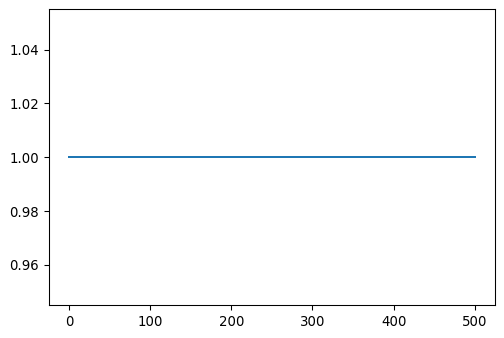

In [19]:
T = 500
X = simulate(lambda x : f(x, 3/4), 1.0, T)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(T+1), X.T)

And $x_0 = 1 + 10^{-15}$ and even a smaller $T$

In [20]:
T = 89
X = simulate(lambda x : f(x, 3/4), 1 + 1e-15, T)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_yscale('log')
ax.plot(range(T+1), X.T)

Notice the `log` scale on the axis. Briefly interpret these results

Since we have found earlier in the question that x=1 is a fixed point, when we start x0 at the fixed point itself, it will not move away from the fixed point at all. As such, it is a straight line.

However, once x is moved away from the fixed point by even a little (in this by just 1^e-15), the graph starts to diverge exponentially towards positive infinity (as evidenced by the log scale). The log scale also means that the divergence at the starting few might not be immediately visible, although it is happening.

# Q5

Find some economic or financial data on the web of your choice

1.  Download it and load it into a pandas dataframe
2.  Either run PCA or k-means clustering on the data
3.  Briefly intrepret the results in whatever way you wish

We are not giving you a list of possible datasources because we want you
to explore to look for interesting sources of data.

The economic rational for looking for the dimension reduction or the
clustering doesn’t need to be especially tight, but do your best to
explain why you ran the particular specification.

For the data, post a link to where you found it but: no need to have it
automatically downloaded in the notebook, and no need to post it up with
your problem set.

In [10]:
df=pd.read_csv("ECON526 PS4 Q5 PWT.csv")
columnsneeded = ['GDP Growth','Scaled GDP']
X = df[columnsneeded]
print(X)


     GDP Growth  Scaled GDP
0      3.618805   48.198859
1     -0.157115   14.500331
2      2.616695   25.647514
3      1.907361   19.281724
4     -2.194852  110.130510
..          ...         ...
152    3.266747   57.514779
153    3.588782   10.520269
154    0.368320   22.001385
155    0.036859    5.343468
156    0.868480    5.196710

[157 rows x 2 columns]


In [15]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=4)  # Using 2 clusters
df['Cluster'] = kmeans.fit_predict(X_scaled)

c:\Users\Ryan Quek\Documents\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [16]:



scatter=plt.scatter(df['Scaled GDP'], df['GDP Growth'], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k')
# Add titles and labels
plt.title('K-means Clustering of Countries')
plt.xlabel('Scaled GDP (US=100)')
plt.ylabel('Annualised Growth')
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Clusters")
plt.grid()
plt.show()



In [17]:
for cluster in df['Cluster'].unique():
    countries_in_cluster = df[df['Cluster'] == cluster]['Country']
    print(f"\nCountries in Cluster {cluster}:")
    print(countries_in_cluster.tolist())


Countries in Cluster 2:
['Aruba', 'Bulgaria', 'Bhutan', 'Botswana', 'China', 'Cyprus', 'Equatorial Guinea', 'Grenada', 'Indonesia', 'Saint Kitts and Nevis', 'Republic of Korea', "Lao People's DR", 'Sri Lanka', 'Maldives', 'Mali', 'Malta', 'Myanmar', 'Mauritius', 'Malaysia', 'Romania', 'Seychelles', 'Turks and Caicos Islands', 'Thailand', 'Taiwan', 'British Virgin Islands', 'Viet Nam']

Countries in Cluster 0:
['Angola', 'Burundi', 'Bahamas', 'Barbados', 'Central African Republic', "Côte d'Ivoire", 'Cameroon', 'D.R. of the Congo', 'Comoros', 'Djibouti', 'Gabon', 'Ghana', 'Guinea', 'Gambia', 'Guinea-Bissau', 'Honduras', 'Haiti', 'Iran (Islamic Republic of)', 'Jamaica', 'Jordan', 'Kenya', 'Lebanon', 'Liberia', 'Madagascar', 'Mauritania', 'Malawi', 'Niger', 'Nicaragua', 'Senegal', 'Sierra Leone', 'Sao Tome and Principe', 'Syrian Arab Republic', 'Chad', 'Togo', 'Uganda', 'Venezuela (Bolivarian Republic of)', 'South Africa', 'Zambia', 'Zimbabwe']

Countries in Cluster 3:
['Anguilla', 'Alban

This contains data from the Penn World Tables (https://www.rug.nl/ggdc/productivity/pwt/), specifically, GDP and the population. I took the country GDP and population information from 1970 and 2015, and used it to get the GDP per capita and the annualised GDP per capita growth. 
The main aim was to see if the Solow-Swan model held true, where lesser economically developed countries would grow faster.

To make for better comparisons, I indexed the GDP such that the 1970 US was set to 100, and as such all countries' GDP per capita were being benchmarked to the US for easier comparison.

After looking at the initial scatter plot, I decided to use 5 clusters. This aimed to cover countries that did not really grow despite low GDP, countries that had normal growth, and those that expanded rapidly. Similarly, for countries that started with higher GDP, I wanted to group those with positive growth and separate them from those with negative growth to see if there was a noticeable trend within the countries. 

The results showed that the countries in cluster 0 (low starting  GDP, negative growth) were generally countries in Africa.

Those in cluster 1 (High starting GDP, normal growth) were generally the developed countries, which was to be expected.

Those in cluster 2 (Low starting GDP, high growth) were mostly in Asia and a handful of countries from other continents that were relatively less developed in the early 70s eg. Bulgaria, Grenada.

Those in Cluster 3 (Low starting GDP, normal growth) are rather mixed, they generally encompass the rest of the countries not spotted.

Those in Cluster 4 (High starting GDP, negative growth) was interesting. These were basically countries in the Middle East, and Brunei. All of them generally are oil rich countries, and perhaps, the negative growth has to do with oil prices rather than their economy itself.